In [2]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [4]:
url = 'http://mattmahoney.net/dc/'

# Download a file if not present, and make sure it's the right size."""


def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [5]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [6]:
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [7]:
print(words[0:5])

['anarchism', 'originated', 'as', 'a', 'term']


In [ ]:
#####################################################################

In [8]:
vocabulary_size = 50000


def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

In [10]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]


In [13]:
data_index = 0


def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'anarchism', 'originated', 'originated', 'of', 'as', 'term']


In [15]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [17]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.128811


Nearest to known: marathi, imitates, psychology, confederal, burgos, bounty, icd, bono,
Nearest to was: jacoby, glass, doctorow, propanol, oratio, barometer, administered, spacetime,
Nearest to this: seleucus, distance, alle, relative, kashrut, spotted, mst, bureaucrats,
Nearest to first: cumbric, orl, belgian, goodness, anomalous, alomar, reformers, nter,
Nearest to new: cradle, typhoons, dispositions, form, shading, months, gomoku, brigades,
Nearest to which: espa, formulae, augusti, cornaro, eldorado, infield, bonnie, banishment,
Nearest to about: popping, ltd, bloodshed, sues, develop, rabelais, hz, battuta,
Nearest to there: eps, decreed, practicing, circling, brescia, disbanding, plausible, insensitive,
Nearest to one: coleridge, gunfire, mad, orr, faber, avogadro, pederastic, librarian,
Nearest to b: leaguers, extermination, catchment, rinks, cedar, undergone, inadequacy, spotty,
Nearest to s: wanton, retard, joanie, adornment, digits, fortune, frud, inhibits,
Nearest to and: re

Average loss at step 2000: 4.374307


Average loss at step 4000: 3.880069


Average loss at step 6000: 3.797068


Average loss at step 8000: 3.758192


Average loss at step 10000: 3.629045
Nearest to known: tiberias, confederal, uncanny, bahasa, well, gambier, spur, such,
Nearest to was: is, has, were, by, are, sittings, had, became,
Nearest to this: it, which, that, the, distance, some, a, fled,
Nearest to first: gracefully, cumbric, racist, hanks, belgian, orl, aristocratic, heating,
Nearest to new: cradle, form, bikram, storyline, maladaptive, roleplay, gomoku, florida,
Nearest to which: that, this, it, but, also, masurian, ounce, espa,
Nearest to about: popping, bloodshed, develop, vide, ltd, leased, filkers, wettest,
Nearest to there: they, it, recently, circling, mich, eps, nominations, not,
Nearest to one: two, seven, six, eight, three, nine, four, five,
Nearest to b: catchment, extermination, g, daw, toed, luthier, inadequacy, fastest,
Nearest to s: frauds, untouchables, pir, his, shamash, gulfs, geysers, computations,
Nearest to and: or, in, for, of, from, against, with, at,
Nearest to six: eight, five, seven, four, nine, thr

Average loss at step 12000: 3.580545


Average loss at step 14000: 3.615840


Average loss at step 16000: 3.586020


Average loss at step 18000: 3.573310


Average loss at step 20000: 3.549065
Nearest to known: used, well, seen, such, uncanny, tiberias, banu, borman,
Nearest to was: is, had, were, became, by, has, been, took,
Nearest to this: it, which, the, he, monza, his, that, hegelians,
Nearest to first: second, latter, racist, kristeva, timberlake, same, battlecruiser, aristocratic,
Nearest to new: ego, small, southward, enix, maladaptive, molestation, bikram, talkative,
Nearest to which: that, this, also, but, what, it, sterreich, binitarianism,
Nearest to about: develop, popping, ltd, vide, despite, inauguration, bloodshed, raccoons,
Nearest to there: they, it, he, talmadge, recently, zea, continuo, mich,
Nearest to one: seven, two, three, six, nine, eight, four, five,
Nearest to b: k, g, extermination, d, luthier, daw, blissymbolics, c,
Nearest to s: his, and, politicians, of, diversion, frauds, pir, zach,
Nearest to and: or, of, but, in, s, poses, were, however,
Nearest to six: seven, five, four, eight, three, nine, zero, two,
Ne

Average loss at step 22000: 3.532656


Average loss at step 24000: 3.449013


Average loss at step 26000: 3.422841


Average loss at step 28000: 3.479955


Average loss at step 30000: 3.411408
Nearest to known: such, used, well, seen, naka, banu, marathi, tiberias,
Nearest to was: is, had, were, became, has, took, been, be,
Nearest to this: it, which, the, what, some, there, that, a,
Nearest to first: second, same, racist, last, timberlake, enacts, blessed, kristeva,
Nearest to new: small, range, maladaptive, ego, latest, bikram, southward, faerie,
Nearest to which: that, this, often, also, who, there, it, childless,
Nearest to about: develop, popping, ltd, despite, sacrificed, bec, versailles, bloodshed,
Nearest to there: it, they, he, we, which, still, now, talmadge,
Nearest to one: six, seven, four, five, eight, nine, telomeres, two,
Nearest to b: d, penalized, centralizing, blissymbolics, skeleton, accumulated, fastest, beretta,
Nearest to s: aardvarks, frauds, presided, bilaterally, ecclesiae, politicians, venerate, sequencer,
Nearest to and: or, but, who, however, which, towards, in, american,
Nearest to six: seven, eight, four, fiv

Average loss at step 32000: 3.420378


Average loss at step 34000: 3.442637


Average loss at step 36000: 3.369017


Average loss at step 38000: 3.493784


Average loss at step 40000: 3.440573
Nearest to known: such, used, well, seen, naka, marathi, banu, tiberias,
Nearest to was: is, were, became, had, has, be, naturalistic, when,
Nearest to this: which, it, the, that, what, some, excess, imperialist,
Nearest to first: second, last, same, kristeva, latter, transferable, best, following,
Nearest to new: latest, small, southward, bikram, ego, asterism, kajang, range,
Nearest to which: that, this, also, who, it, and, but, often,
Nearest to about: popping, bec, sacrificed, ltd, develop, despite, inauguration, wettest,
Nearest to there: they, it, we, he, which, said, purchasers, still,
Nearest to one: six, seven, eight, two, five, nine, four, mackay,
Nearest to b: d, centralizing, johnston, matrix, gal, tons, gnostic, beretta,
Nearest to s: his, exploited, politicians, frauds, joanie, its, chronological, was,
Nearest to and: or, but, which, however, from, unravel, recites, upanija,
Nearest to six: eight, seven, five, four, nine, zero, three, 

Average loss at step 42000: 3.426025


Average loss at step 44000: 3.283995


Average loss at step 46000: 3.407159


Average loss at step 48000: 3.434435


Average loss at step 50000: 3.439540
Nearest to known: used, such, seen, well, possible, available, superstitious, naka,
Nearest to was: is, has, became, had, were, becomes, when, southside,
Nearest to this: which, it, the, some, khans, fisheries, kellerman, that,
Nearest to first: second, last, latter, third, next, same, following, kristeva,
Nearest to new: latest, asterism, maladaptive, roleplay, brigades, small, presidential, faerie,
Nearest to which: this, that, who, what, often, childless, there, also,
Nearest to about: popping, ltd, bec, reliably, azores, develop, despite, inauguration,
Nearest to there: they, it, he, we, still, she, sometimes, munro,
Nearest to one: seven, two, eight, five, six, four, nine, three,
Nearest to b: d, c, k, centralizing, dries, trans, luthier, archeological,
Nearest to s: his, although, and, politicians, whose, tractate, zach, pir,
Nearest to and: or, but, however, unravel, with, while, which, although,
Nearest to six: seven, eight, five, four, nine

Average loss at step 52000: 3.456288


Average loss at step 54000: 3.429660


Average loss at step 56000: 3.408319


Average loss at step 58000: 3.279366


Average loss at step 60000: 3.381498
Nearest to known: used, such, subtractive, seen, possible, well, available, classified,
Nearest to was: is, were, became, had, has, when, been, becomes,
Nearest to this: which, it, that, another, some, nasl, khans, the,
Nearest to first: second, last, next, third, latter, mandaeanism, same, best,
Nearest to new: asterism, small, latest, measles, maladaptive, ego, faerie, enix,
Nearest to which: that, this, who, also, it, what, but, there,
Nearest to about: bec, despite, popping, develop, ltd, on, condorcet, sacrificed,
Nearest to there: it, they, he, she, still, today, now, ensembles,
Nearest to one: two, four, eight, six, five, seven, three, telomeres,
Nearest to b: d, k, c, r, f, p, unam, centralizing,
Nearest to s: politicians, pir, voodoo, wanton, his, callimico, scenario, frauds,
Nearest to and: or, including, but, towards, nor, however, which, in,
Nearest to six: eight, five, seven, four, nine, three, two, zero,
Nearest to see: list, masochism

Average loss at step 62000: 3.440544


Average loss at step 64000: 3.362700


Average loss at step 66000: 3.344405


Average loss at step 68000: 3.387849


Average loss at step 70000: 3.371417
Nearest to known: used, such, subtractive, seen, well, named, being, possible,
Nearest to was: is, were, became, has, had, becomes, be, by,
Nearest to this: which, it, the, another, hegelians, each, stooges, anachronistic,
Nearest to first: second, last, next, original, third, latter, same, timberlake,
Nearest to new: maladaptive, asterism, latest, faerie, cup, small, repay, principal,
Nearest to which: this, that, also, who, engaged, homeomorphic, soliah, still,
Nearest to about: unprepared, sade, bec, popping, condorcet, despite, baudelaire, develop,
Nearest to there: they, it, still, he, we, she, often, sometimes,
Nearest to one: eight, six, two, seven, three, nine, four, five,
Nearest to b: d, k, r, c, y, p, f, g,
Nearest to s: whose, pir, politicians, his, wanton, analytics, grazing, cyborgs,
Nearest to and: or, but, including, although, nor, while, towards, cker,
Nearest to six: eight, seven, nine, four, five, three, zero, two,
Nearest to see:

Average loss at step 72000: 3.403416


Average loss at step 74000: 3.391914


Average loss at step 76000: 3.350046


Average loss at step 78000: 3.241312


Average loss at step 80000: 3.376608
Nearest to known: used, possible, seen, such, named, subtractive, classified, well,
Nearest to was: is, were, had, has, became, becomes, be, been,
Nearest to this: which, it, another, the, what, each, hegelians, some,
Nearest to first: second, last, original, next, third, same, latter, montreux,
Nearest to new: maladaptive, repay, asterism, mathematical, latest, foreman, lacrosse, ruud,
Nearest to which: this, that, also, what, usually, typically, who, often,
Nearest to about: unprepared, sade, approximately, bec, bloodshed, con, elevates, popping,
Nearest to there: they, it, he, she, we, still, sometimes, now,
Nearest to one: two, seven, six, five, eight, three, nine, four,
Nearest to b: d, c, y, k, bb, f, trans, x,
Nearest to s: whose, his, constriction, your, sue, venerated, doesn, zach,
Nearest to and: or, kinsella, while, of, including, but, apulia, bureaucrat,
Nearest to six: four, five, seven, eight, three, nine, zero, two,
Nearest to see: li

Average loss at step 82000: 3.304359


Average loss at step 84000: 3.337753


Average loss at step 86000: 3.346275


Average loss at step 88000: 3.325236


Average loss at step 90000: 3.241730
Nearest to known: used, such, subtractive, seen, opposed, defined, described, available,
Nearest to was: is, had, were, became, has, been, although, be,
Nearest to this: which, it, midshipman, the, another, some, khans, seleucus,
Nearest to first: second, last, next, third, original, best, latter, montreux,
Nearest to new: maladaptive, enix, ruud, piano, dyslexia, faerie, florida, hottest,
Nearest to which: that, this, also, who, what, often, typically, usually,
Nearest to about: unprepared, sade, wanton, on, approximately, popping, develop, azores,
Nearest to there: they, it, he, she, we, still, sometimes, now,
Nearest to one: two, seven, five, three, six, four, eight, nine,
Nearest to b: d, centralizing, c, and, trans, bb, intersystems, p,
Nearest to s: whose, politicians, his, wanton, eero, and, walkers, jamal,
Nearest to and: or, including, american, but, of, glover, b, harem,
Nearest to six: four, eight, seven, nine, three, five, zero, two,
Nea

Average loss at step 92000: 2.738678


Average loss at step 94000: 3.102034


Average loss at step 96000: 3.066038


Average loss at step 98000: 3.218827


Average loss at step 100000: 3.284976
Nearest to known: used, such, subtractive, possible, available, defined, seen, described,
Nearest to was: is, became, had, has, were, although, be, been,
Nearest to this: which, it, the, some, another, that, anachronistic, his,
Nearest to first: second, last, next, third, fourth, original, montreux, latter,
Nearest to new: maladaptive, ruud, faerie, hottest, piano, cup, modern, dyslexia,
Nearest to which: that, this, who, what, typically, also, often, usually,
Nearest to about: unprepared, concerning, sacrificed, osborn, wanton, raccoons, azores, develop,
Nearest to there: it, they, we, he, she, now, still, often,
Nearest to one: two, four, seven, six, five, three, nine, eight,
Nearest to b: d, centralizing, milt, pdp, laureate, gal, undisputed, pall,
Nearest to s: whose, his, isbn, although, james, secant, buick, marion,
Nearest to and: or, but, including, towards, kinsella, however, although, which,
Nearest to six: seven, five, eight, four, nine,

In [18]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

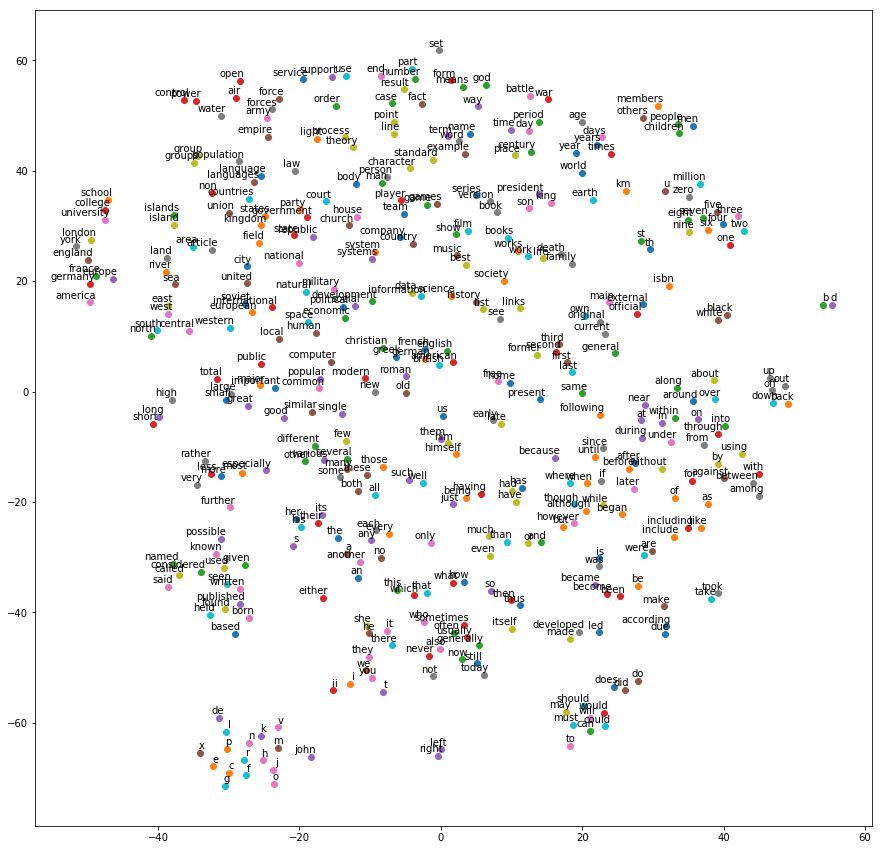

In [20]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)